In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 03_visuals — Polished Figures for Report & README

This notebook generates **publication-ready visuals** from the cleaned dataset:
1) Top 10 cities by GDP (latest year) — labeled, horizontal bars  
2) YoY GDP growth leaders — lollipop chart  
3) GDP trends for top 5 cities — annotated lines  
4) Sector mix by city (stacked bars, latest year)  
5) (If available) Productivity vs Unemployment — scatter with best-fit line

All figures are saved to `Reports/Figures/` in Google Drive for easy download and mirroring into the repo’s `reports/figures/`.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# High-res plots
plt.rcParams["figure.dpi"] = 150
sns.set_theme()

# Root folder in Drive (adjust only if you moved the project)
ROOT = Path("/content/drive/MyDrive/GitHub/01 indian-cities-gdp-2019-2024")

CLEAN_FILE   = ROOT / "Cleaned Data/indian_cities_gdp_productivity.csv"
FIGURES_DIR  = ROOT / "Reports/Figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

CLEAN_FILE, FIGURES_DIR


(PosixPath('/content/drive/MyDrive/GitHub/01 indian-cities-gdp-2019-2024/Cleaned Data/indian_cities_gdp_productivity.csv'),
 PosixPath('/content/drive/MyDrive/GitHub/01 indian-cities-gdp-2019-2024/Reports/Figures'))

In [3]:
df = pd.read_csv(CLEAN_FILE)
latest_year = int(df["year"].max())
df.head(), latest_year


(        city  year  gdp_billion_usd  agriculture_pct  industry_pct  \
 0  Ahmedabad  2019            187.2             15.7          32.1   
 1  Ahmedabad  2020            211.5             11.6          37.8   
 2  Ahmedabad  2021            247.9             12.9          31.4   
 3  Ahmedabad  2022             71.8              5.3          36.7   
 4  Ahmedabad  2023            294.7             17.0          29.2   
 
    services_pct  technology_pct  r&d_expenditure_pct_of_gdp  \
 0          40.9            20.6                        1.06   
 1          49.3            19.6                        1.93   
 2          48.5            11.8                        1.60   
 3          45.6            31.8                        1.40   
 4          45.6            13.0                        0.73   
 
    patents_per_100,000_inhabitants  unemployment_rate_pct  \
 0                              3.4                    5.6   
 1                              2.1                    6.6   


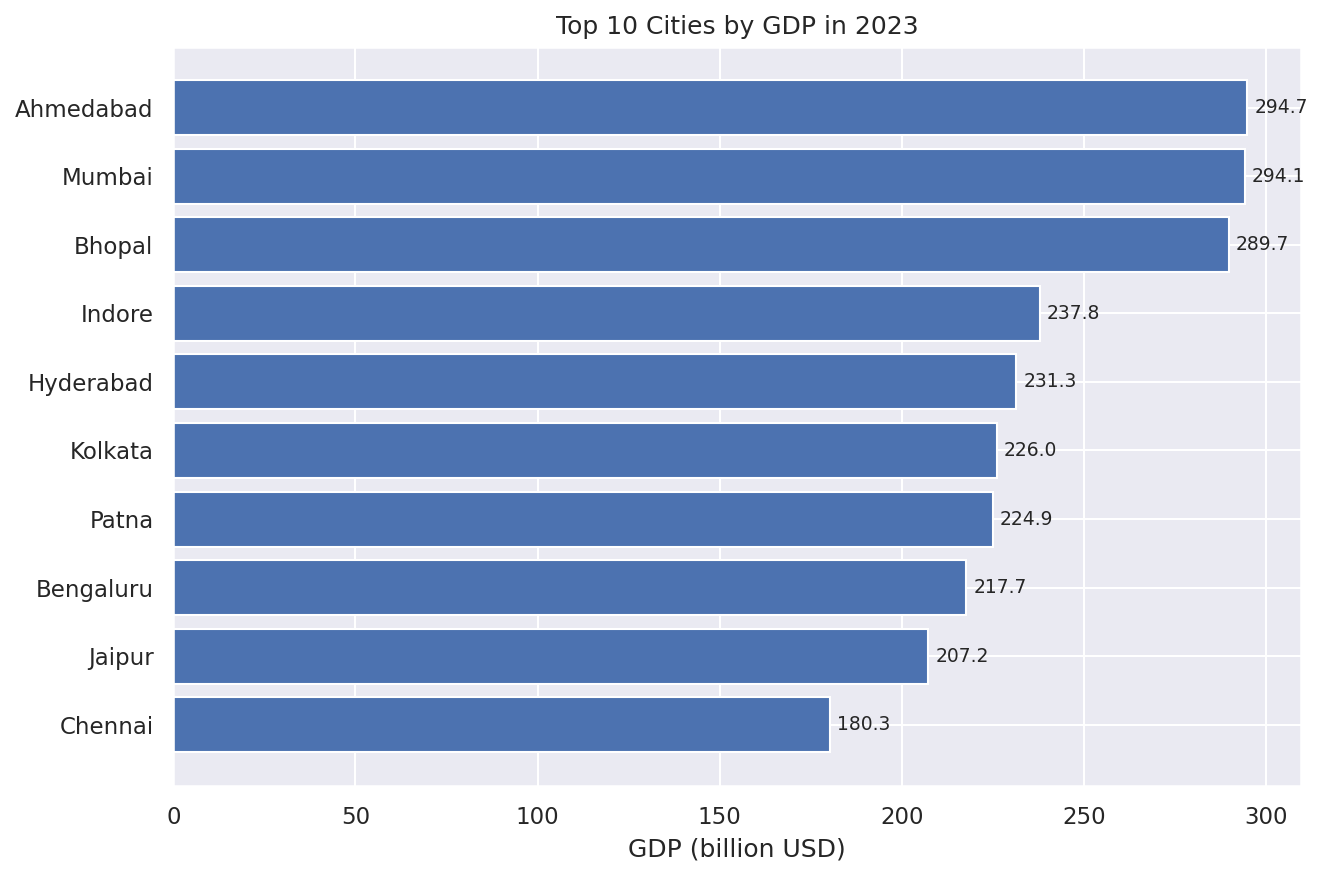

PosixPath('/content/drive/MyDrive/GitHub/01 indian-cities-gdp-2019-2024/Reports/Figures/01_top10_gdp_2023.png')

In [5]:
top10 = (
    df[df["year"] == latest_year]
    .nlargest(10, "gdp_billion_usd")
    .sort_values("gdp_billion_usd")
)

fig, ax = plt.subplots(figsize=(9,6))
ax.barh(top10["city"], top10["gdp_billion_usd"])

# Add labels at end of bars (just shift a little to the right of the bar)
for i, v in enumerate(top10["gdp_billion_usd"]):
    ax.text(v + 2, i, f"{v:.1f}", va="center", ha="left", fontsize=9)

ax.set_title(f"Top 10 Cities by GDP in {latest_year}")
ax.set_xlabel("GDP (billion USD)")
ax.set_ylabel("")
plt.tight_layout()

p = FIGURES_DIR / f"01_top10_gdp_{latest_year}.png"
plt.savefig(p, dpi=300, bbox_inches="tight")
plt.show()
p


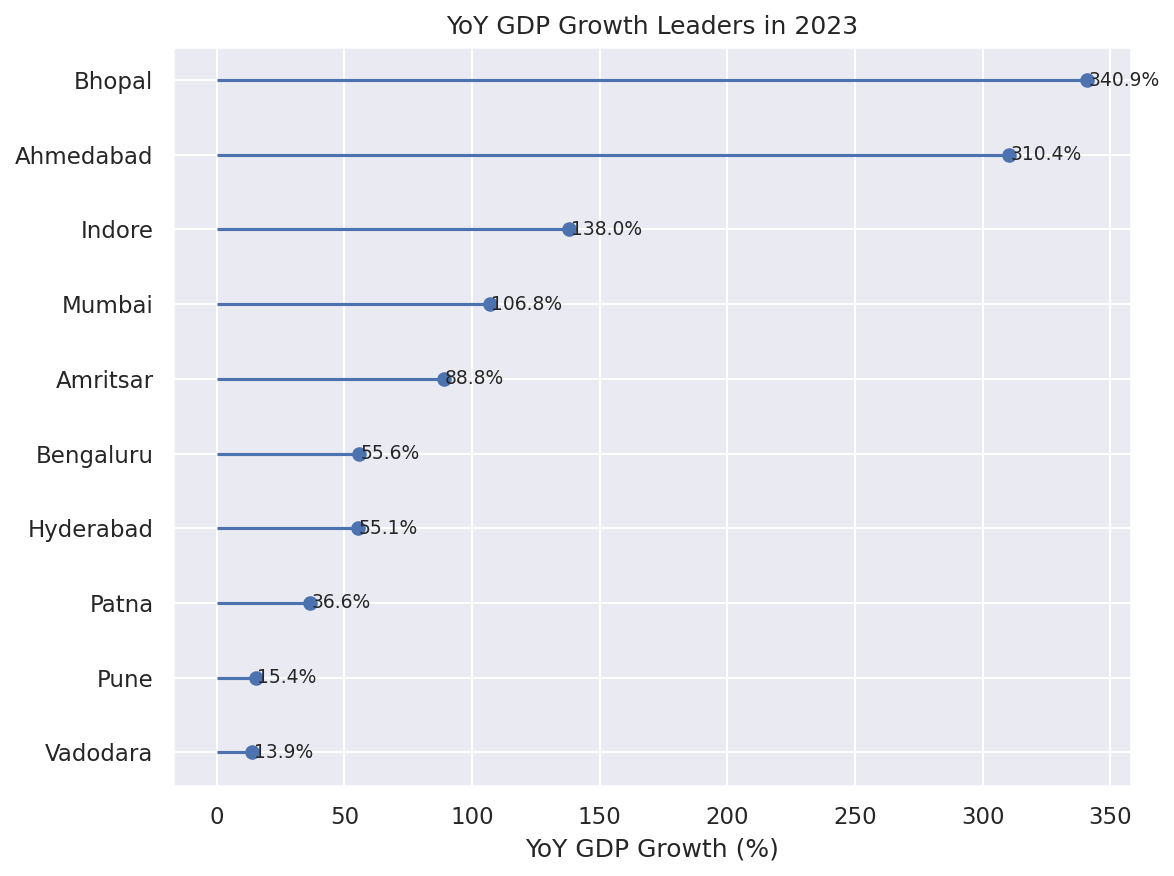

PosixPath('/content/drive/MyDrive/GitHub/01 indian-cities-gdp-2019-2024/Reports/Figures/02_yoy_growth_leaders_2023.png')

In [6]:
# Compute latest YoY by city
latest = df[df["year"] == latest_year].copy()
growth = (
    latest[["city", "gdp_yoy_pct"]]
    .dropna()
    .sort_values("gdp_yoy_pct", ascending=False)
    .head(10)
    .sort_values("gdp_yoy_pct")
)

fig, ax = plt.subplots(figsize=(8,6))
ax.hlines(y=growth["city"], xmin=0, xmax=growth["gdp_yoy_pct"])
ax.plot(growth["gdp_yoy_pct"], growth["city"], "o")

# Add value labels slightly to the right of each point (no xytext/textcoords)
for y, x in zip(growth["city"], growth["gdp_yoy_pct"]):
    ax.text(x + 0.5, y, f"{x:.1f}%", va="center", ha="left", fontsize=9)

ax.set_title(f"YoY GDP Growth Leaders in {latest_year}")
ax.set_xlabel("YoY GDP Growth (%)")
ax.set_ylabel("")
plt.tight_layout()

p = FIGURES_DIR / f"02_yoy_growth_leaders_{latest_year}.png"
plt.savefig(p, dpi=300, bbox_inches="tight")
plt.show()
p


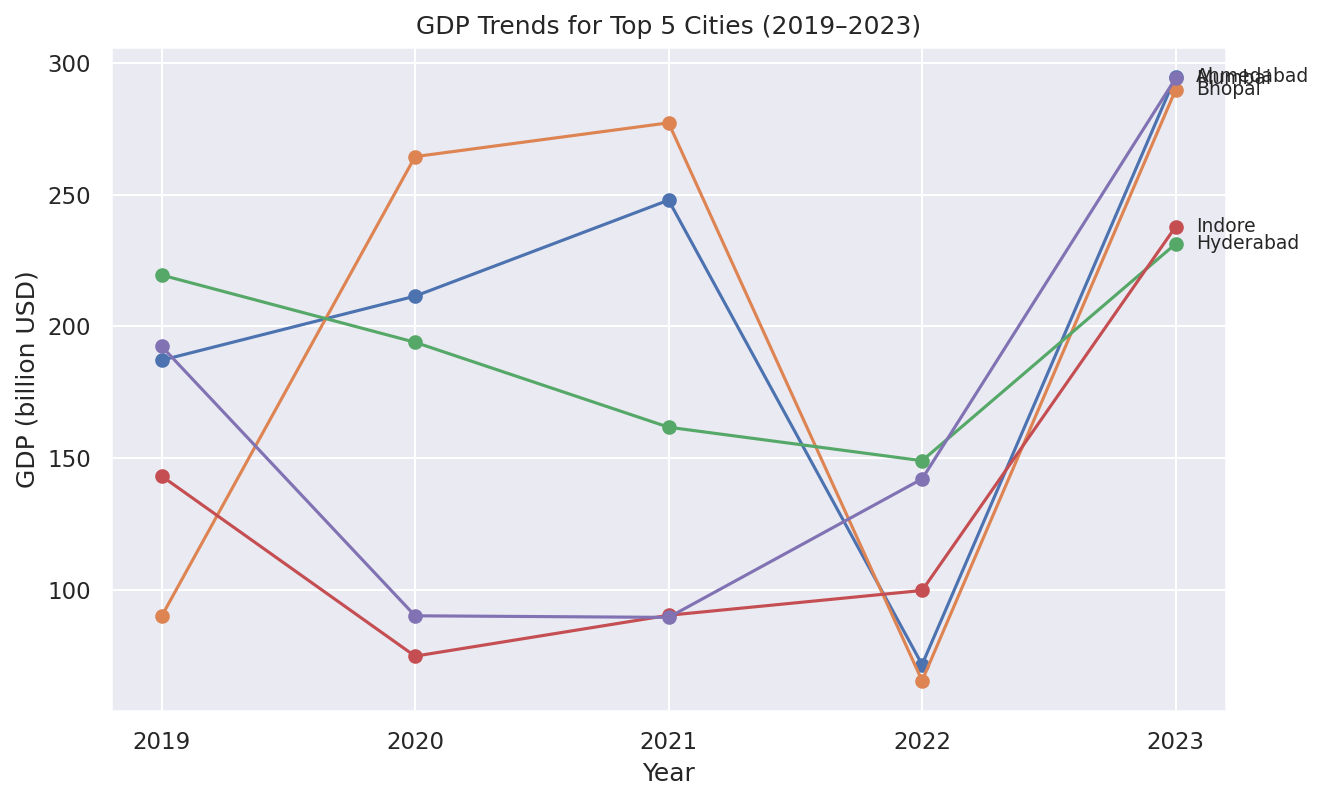

PosixPath('/content/drive/MyDrive/GitHub/01 indian-cities-gdp-2019-2024/Reports/Figures/03_trends_top5_2023.png')

In [7]:
# Pick top 5 by latest GDP
latest_year = int(df["year"].max())
top5_cities = (
    df[df["year"] == latest_year]
    .nlargest(5, "gdp_billion_usd")["city"].tolist()
)

subset = df[df["city"].isin(top5_cities)].copy()

fig, ax = plt.subplots(figsize=(9,5.5))
years_sorted = sorted(df["year"].unique())
ax.set_xticks(years_sorted)

for city, g in subset.groupby("city"):
    g = g.sort_values("year")
    ax.plot(g["year"], g["gdp_billion_usd"], marker="o", label=city)
    # annotate last point a little to the right
    last = g.iloc[-1]
    ax.text(float(last["year"]) + 0.08, last["gdp_billion_usd"], city, va="center", fontsize=9)

ax.set_title(f"GDP Trends for Top 5 Cities (2019–{latest_year})")
ax.set_xlabel("Year")
ax.set_ylabel("GDP (billion USD)")
plt.tight_layout()

p = FIGURES_DIR / f"03_trends_top5_{latest_year}.png"
plt.savefig(p, dpi=300, bbox_inches="tight")
plt.show()
p


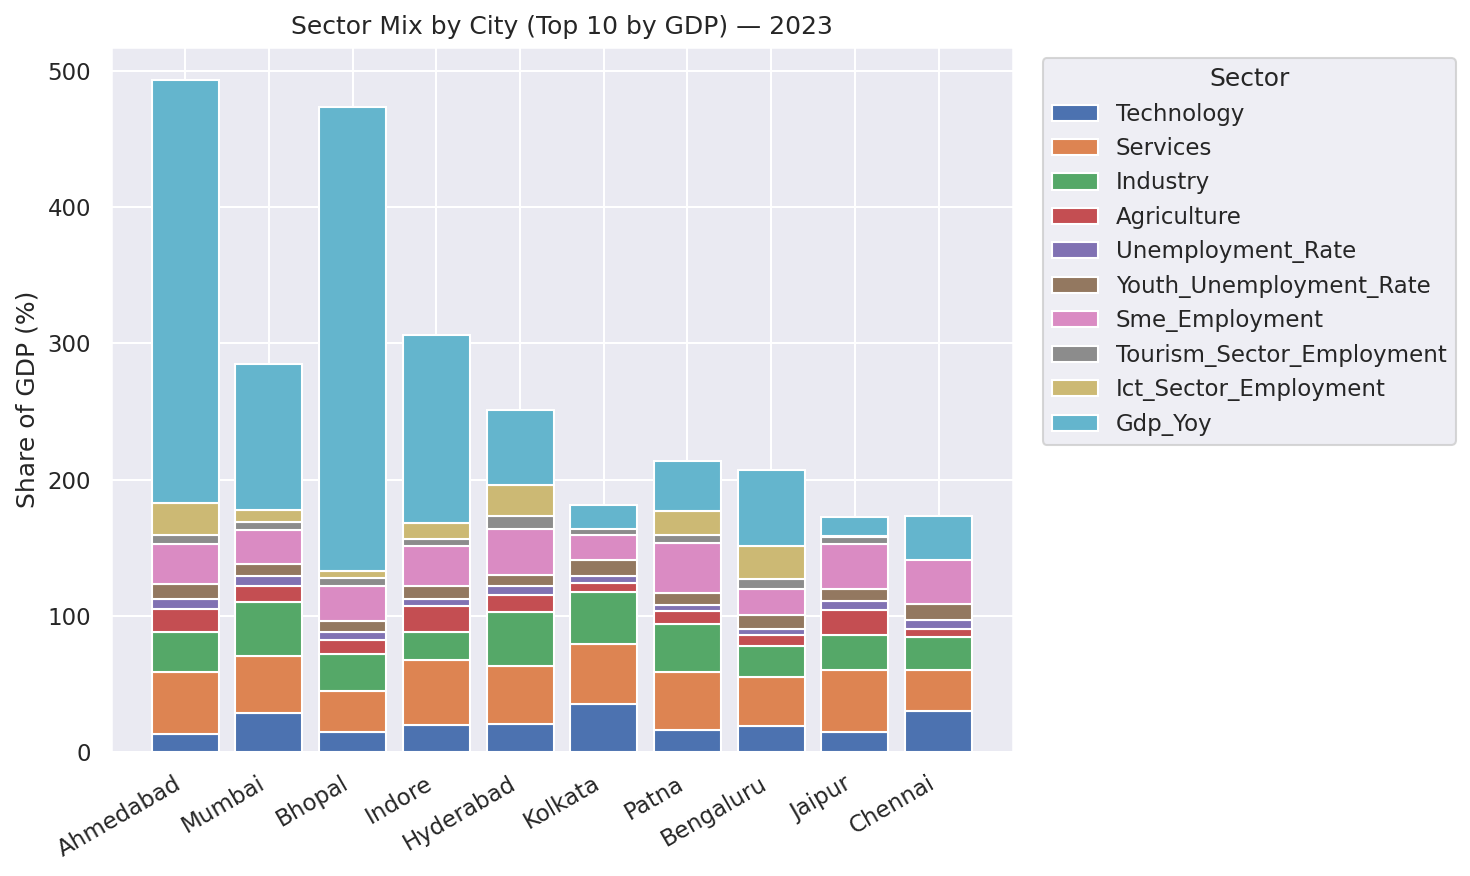

In [8]:
import numpy as np

latest_year = int(df["year"].max())
sector_cols = [c for c in df.columns if c.endswith("_pct")]
latest_top10 = (
    df[df["year"] == latest_year]
    .nlargest(10, "gdp_billion_usd")
    .copy()
)

if sector_cols:
    # Consistent sector order if present
    order_hint = ["technology_pct", "services_pct", "industry_pct", "agriculture_pct"]
    sectors_ordered = [c for c in order_hint if c in sector_cols] + [c for c in sector_cols if c not in order_hint]

    fig, ax = plt.subplots(figsize=(10,6))
    bottom = np.zeros(len(latest_top10))
    x = np.arange(len(latest_top10))

    for col in sectors_ordered:
        ax.bar(latest_top10["city"], latest_top10[col], bottom=bottom, label=col.replace("_pct","").title())
        bottom += latest_top10[col].to_numpy()

    ax.set_title(f"Sector Mix by City (Top 10 by GDP) — {latest_year}")
    ax.set_ylabel("Share of GDP (%)")
    ax.set_xlabel("")
    plt.xticks(rotation=30, ha="right")
    ax.legend(title="Sector", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()

    p = FIGURES_DIR / f"04_sector_mix_top10_{latest_year}.png"
    plt.savefig(p, dpi=300, bbox_inches="tight")
    plt.show()
    p
else:
    print("No sector percentage columns found.")


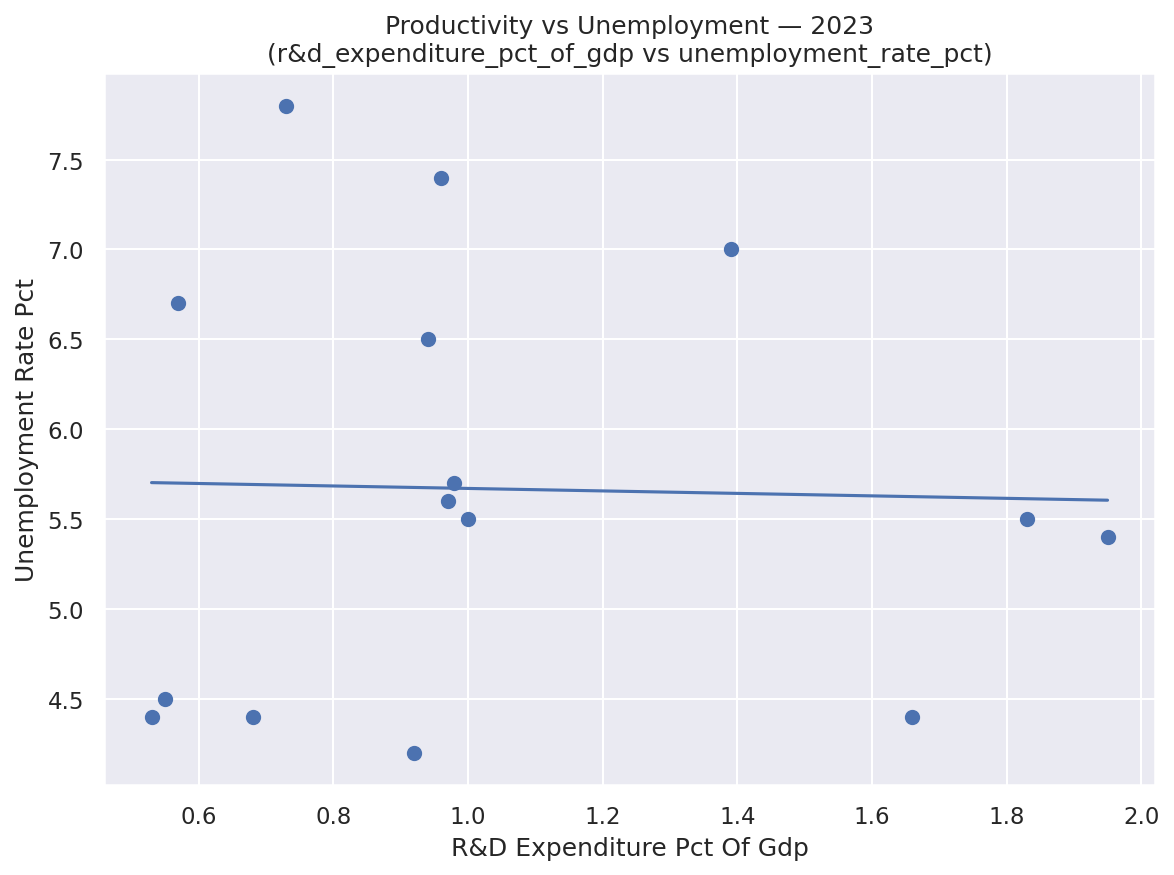

In [9]:
import numpy as np

latest_year = int(df["year"].max())

# Heuristic search for a "productivity-like" and "unemployment" column
prod_like = [c for c in df.columns if "patents_per_100000" in c or "r&d" in c or "rd" in c or "ict_sector_employment" in c]
unemp_like = [c for c in df.columns if "unemployment_rate_pct" in c and "youth" not in c]

if prod_like and unemp_like:
    prod = prod_like[0]
    unemp = unemp_like[0]

    data_latest = df[df["year"] == latest_year].copy().dropna(subset=[prod, unemp, "gdp_billion_usd"])
    if not data_latest.empty:
        fig, ax = plt.subplots(figsize=(8,6))
        ax.scatter(data_latest[prod], data_latest[unemp], s=40)

        # Best-fit line
        m, b = np.polyfit(data_latest[prod], data_latest[unemp], 1)
        x_line = np.linspace(data_latest[prod].min(), data_latest[prod].max(), 100)
        ax.plot(x_line, m*x_line + b)

        ax.set_title(f"Productivity vs Unemployment — {latest_year}\n({prod} vs {unemp})")
        ax.set_xlabel(prod.replace("_"," ").title())
        ax.set_ylabel(unemp.replace("_"," ").title())
        plt.tight_layout()

        p = FIGURES_DIR / f"05_productivity_vs_unemployment_{latest_year}.png"
        plt.savefig(p, dpi=300, bbox_inches="tight")
        plt.show()
        p
    else:
        print("No rows with required columns for scatter in the latest year.")
else:
    print("Could not find suitable productivity or unemployment columns automatically.")


In [10]:
latest_year = int(df["year"].max())

cols = ["city", "gdp_billion_usd", "gdp_yoy_pct"] + [c for c in df.columns if c.endswith("_pct")]
cols = [c for c in cols if c in df.columns]  # guard against missing cols

highlights = (
    df[df["year"] == latest_year]
    .loc[:, cols]
    .sort_values("gdp_billion_usd", ascending=False)
    .head(15)
)
out = ROOT / "Reports/top_cities_highlights.csv"
highlights.to_csv(out, index=False)
highlights, out


(         city  gdp_billion_usd  gdp_yoy_pct  agriculture_pct  industry_pct  \
 4   Ahmedabad            294.7   310.445682             17.0          29.2   
 59     Mumbai            294.1   106.821378             12.0          39.5   
 19     Bhopal            289.7   340.943683             10.3          27.1   
 39     Indore            237.8   138.038038             18.9          20.6   
 34  Hyderabad            231.3    55.130785             12.5          39.1   
 49    Kolkata            226.0   -17.548340              6.5          38.4   
 64      Patna            224.9    36.551305              9.9          35.1   
 14  Bengaluru            217.7    55.611151              8.2          22.6   
 44     Jaipur            207.2   -13.522538             18.1          25.5   
 24    Chennai            180.3   -31.704545              5.8          24.0   
 9    Amritsar            175.6    88.817204             19.1          32.7   
 69       Pune            172.6    15.374332        